### Initiating Google Colab

In [ ]:
from google.colab import drive, auth

drive.mount('/content/drive', force_remount=True)
auth.authenticate_user()

BUCKET_NAME = 'cancer_detection_colab'
! gsutil ls gs://{BUCKET_NAME}

### Importing Libraries

In [1]:
import sys
LIBRARY_DIR = '/home/sven/Python/TensorFlow-Training/Text'
# LIBRARY_DIR = '/content/drive/My Drive'
sys.path.append(LIBRARY_DIR)

import pandas as pd
import tensorflow as tf
import os
import time
from math import ceil as ceil
import datetime
import logging

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from utils.models.skin_cancer_detector import create_labels_with_counts, sort_samples, create_dataset, load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

# disable warnings and infos
logging.disable(logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

tf.__version__

'2.3.0'

### Initiating a GPU strategy

In [2]:
for gpu in tf.config.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, enable=True)
    
strategy = tf.distribute.MirroredStrategy()

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


### Initiating a TPU strategy

In [ ]:
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    print('Running on TPU: ', resolver.cluster_spec().as_dict())
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime')
    
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy()

### Setting up some parameters

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


BASE_DIR = ''
# BASE_DIR = f'gs://{BUCKET_NAME}'   # for Colab
VERSION = 1
MODEL_DIR = os.path.join(BASE_DIR, 'model', f'{VERSION:04d}')
LOGS_DIR = os.path.join(BASE_DIR, 'logs')
CHECKPOINT_DIR = os.path.join(BASE_DIR, 'checkpoints')
DATASET_DIR = '/home/sven/tensorflow_datasets/skin_cancer_mnist'
# DATASET_DIR = BASE_DIR   # for Colab


BATCH_SIZE = 64 * strategy.num_replicas_in_sync    # divide by 2 for TPU usage
BUFFER_SIZE = 10000
IMAGE_SIZE = [150, 150]
VALIDATION_SPLIT = 0.2 

In [8]:
dataset = pd.read_csv(os.path.join(DATASET_DIR, 'HAM10000_metadata.csv'))
dataset

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [9]:
LABELS, COUNTS = create_labels_with_counts(DATASET_DIR, metadata_file='HAM10000_metadata.csv', key='dx')
for label in LABELS:
    print(f'{COUNTS[label]} samples for label {label}')
    
# Here is an alternative dataset
#gcs_pattern = 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec'
#LABELS = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] 

6705 samples for label nv
1113 samples for label mel
1099 samples for label bkl
514 samples for label bcc
327 samples for label akiec
142 samples for label vasc
115 samples for label df


# Loading the dataset

### Creating a preprocessed dataset

In [4]:
# IMAGE_DIR = os.path.join(DATASET_DIR, 'images')
# sort_samples(source_dir = DATASET_DIR, target_dir = IMAGE_DIR)

# create_dataset(source_dir = IMAGE_DIR,
#                target_dir = DATASET_DIR,   
#                image_size = IMAGE_SIZE,   
#                validation_split = None,   
#                mode = 'tfrecord',   
#                shard_size = 500)

### Using Kera's ImageDataGenerator

In [104]:
image_gen = ImageDataGenerator(rescale = 1./255,
                              # height_shift_range = 0.2,
                              # width_shift_range = 0.2,
                              # rotation_range = 90,
                              # zoom_range = 0.2,
                              # shear_range = 45,
                              # horizontal_flip = True,
                              # vertical_flip = True,
                               validation_split = VALIDATION_SPLIT)

directory = os.path.join(DATASET_DIR, f'{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}')

train_data = image_gen.flow_from_directory(directory = directory, 
                                           target_size = IMAGE_SIZE, 
                                           batch_size = BATCH_SIZE,
                                           class_mode = 'sparse',
                                           subset = 'training',
                                           classes = LABELS)

valid_data = image_gen.flow_from_directory(directory = directory, 
                                           target_size = IMAGE_SIZE, 
                                           batch_size = BATCH_SIZE,
                                           class_mode = 'sparse',
                                           subset = 'validation', 
                                           classes = LABELS)

Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.


### Using Kera's image_dataset_from_directory (requires TF version 2.3)

In [8]:
directory = os.path.join(DATASET_DIR, f'{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}')

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=IMAGE_DIR,
    class_names=LABELS,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    validation_split=VALIDATION_SPLIT,
    subset='training',
    seed=1)

train_data = train_data.map(lambda x,y: (x/255., y), num_parallel_calls=AUTOTUNE)
train_data = train_data.cache().repeat().prefetch(AUTOTUNE)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=IMAGE_DIR,
    class_names=LABELS,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    seed=1)

valid_data = valid_data.map(lambda x,y: (x/255., y), num_parallel_calls=AUTOTUNE)
valid_data = valid_data.cache().repeat().prefetch(AUTOTUNE)
n_train = 8012
n_valid = 2003

Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.


### Creating a (balanced) dataset by hand

In [78]:
mode = 'tfrecord'
train_dir = os.path.join(DATASET_DIR, f'{mode}_{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}', 'training')
valid_dir = os.path.join(DATASET_DIR, f'{mode}_{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}', 'validation')

train_data, n_train = load_dataset(directory=train_dir, 
                          mode=mode, 
                          batch_size=BATCH_SIZE, 
                          balanced=True, 
                          augmented=True,
                          image_size=IMAGE_SIZE)

valid_data, n_valid = load_dataset(directory=valid_dir, 
                          mode=mode, 
                          batch_size=BATCH_SIZE, 
                          balanced=True, 
                          augmented=False,
                          image_size=IMAGE_SIZE)


train_steps = ceil(n_train/BATCH_SIZE)
valid_steps = ceil(n_valid/BATCH_SIZE)
print(f'{n_train} training samples in {train_steps} batches')
print(f'{n_valid} validation samples in {valid_steps} batches')

8015 training samples in 63 batches
2000 validation samples in 16 batches


### Inspecting batch number 10001

loaded the data in 0.327 seconds

image batch has shape (128, 150, 150, 3) and dtype float32
label batch has shape (128,) and dtype int64
number of images per label: [17, 12, 21, 24, 18, 20, 16]

class of first image:  bcc
a part of the first image:
 [[0.8156863  0.827451   0.83137256 0.8235294 ]
 [0.8156863  0.8235294  0.8235294  0.81960785]
 [0.8156863  0.8156863  0.8117647  0.8156863 ]
 [0.8156863  0.8117647  0.8117647  0.8156863 ]]


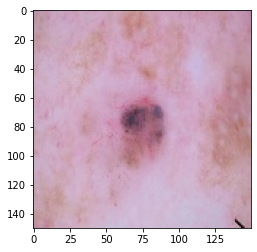

In [79]:
start = time.perf_counter()
x, y = next(iter(valid_data.skip(10000)))
print(f'loaded the data in {time.perf_counter()-start:.3f} seconds\n', )
print(f'image batch has shape {x.shape} and dtype {x.dtype.name}')
print(f'label batch has shape {y.shape} and dtype {y.dtype.name}')

l = 7*[0]
for e in y:
    l[e.numpy()] += 1
print('number of images per label:', l)

print('\nclass of first image: ', LABELS[y[0].numpy()])
print('a part of the first image:\n', x[0,50:54,50:54,0].numpy())
res = plt.imshow(x[0])

In [77]:
x[0].set_shape([*IMAGE_SIZE,3])
x[0].get_shape()

TensorShape([150, 150, 3])

# Buidling and training a model

## 1st Model

In [8]:
with strategy.scope():
    model = Sequential([
            Conv2D(16, [3,3], activation='relu', input_shape=[*IMAGE_SIZE,3]),
            Conv2D(16, [3,3], activation='relu'),
            MaxPooling2D([3,3]),
            Dropout(0.2),
            Conv2D(32, [3,3], activation='relu'),
            Conv2D(32, [3,3], activation='relu'),
            MaxPooling2D([3,3]),
            Dropout(0.2),
            Flatten(),
            Dense(512, activation='relu'),
            Dense(len(LABELS), activation='softmax')
            ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
                 )
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0

In [9]:
ES = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0.001, patience=50, mode='max', restore_best_weights=True)
TB = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(LOGS_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)
model.fit(train_data, 
          validation_data=valid_data, 
          steps_per_epoch=train_steps, 
          epochs=10, 
          validation_steps=valid_steps, 
          verbose=0, 
          callbacks=[ES, TB, LR]
         )

### Inspecting the accuracy of the model

Accuracy: 46.10%
Confusion Matrix


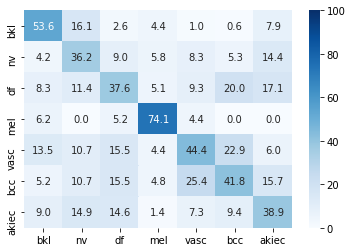

In [40]:
y_pred = tf.constant([], tf.int32)
y_true = tf.constant([], tf.int32)
for x, y in valid_data.take(valid_steps):
    y_pred = tf.concat([y_pred, tf.cast(model.predict_classes(x), tf.int32)], axis=0)
    y_true = tf.concat([y_true, tf.cast(y, tf.int32)], axis=0)
    
cm = tf.math.confusion_matrix(y_true, y_pred)
# cmap = sns.cubehelix_palette(light=1, as_cmap=True)
cmap = 'Blues'
sns.heatmap(100*cm/tf.reduce_sum(cm, axis=1), annot=True, vmin=0.0, vmax=100., 
                  xticklabels = LABELS, yticklabels= LABELS, 
                  fmt='.1f', cmap=cmap)

print(f'Accuracy: {100* tf.reduce_mean(tf.cast(y_true == y_pred, tf.float32)).numpy():.2f}%')
print('Confusion Matrix')

In [53]:
model.save(MODEL_DIR)

## 2nd Model

In [45]:
with strategy.scope():
    model2 = Sequential([
            Conv2D(16, 3, padding = 'same', activation = 'relu', input_shape = [*IMAGE_SIZE, 3]),
            MaxPooling2D(),  # use pool_size = (2,2)
            Conv2D(32, 3, padding = 'same', activation = 'relu'),
            MaxPooling2D(),
            Conv2D(64, 3, padding = 'same', activation = 'relu'),
            MaxPooling2D(),
            Flatten(),
            Dense(512, activation = 'relu'),
            Dense(7, activation='softmax')
        ])
    model2.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                   optimizer = 'adam', 
                   metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
    
    
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 20736)            

In [48]:
ES = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0.001, patience=30, mode='max', restore_best_weights=True)
TB = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(LOGS_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)
model2.fit(train_data, 
          validation_data=valid_data, 
          steps_per_epoch=train_steps, 
          epochs=500, 
          validation_steps=valid_steps, 
          verbose=0, 
          callbacks=[ES, TB]
         )

Epoch 1/500
63/63 [==============================] - 4s 60ms/step - loss: 1.9274 - sparse_categorical_accuracy: 0.2381 - val_loss: 1.6317 - val_sparse_categorical_accuracy: 0.3450
Epoch 2/500
63/63 [==============================] - 2s 36ms/step - loss: 1.6922 - sparse_categorical_accuracy: 0.3265 - val_loss: 1.5208 - val_sparse_categorical_accuracy: 0.3865
Epoch 3/500
63/63 [==============================] - 2s 36ms/step - loss: 1.5979 - sparse_categorical_accuracy: 0.3807 - val_loss: 1.4492 - val_sparse_categorical_accuracy: 0.4330
Epoch 4/500
63/63 [==============================] - 2s 36ms/step - loss: 1.5120 - sparse_categorical_accuracy: 0.4168 - val_loss: 1.3939 - val_sparse_categorical_accuracy: 0.4520
Epoch 5/500
63/63 [==============================] - 2s 36ms/step - loss: 1.4552 - sparse_categorical_accuracy: 0.4425 - val_loss: 1.3900 - val_sparse_categorical_accuracy: 0.4570
Epoch 6/500
63/63 [==============================] - 2s 37ms/step - loss: 1.4180 - sparse_categorica

### Inspecting the accuracy of the model

In [ ]:
y_pred = tf.constant([], tf.int32)
y_true = tf.constant([], tf.int32)
for x, y in valid_data.take(valid_steps):
    y_pred = tf.concat([y_pred, tf.cast(model2.predict_classes(x), tf.int32)], axis=0)
    y_true = tf.concat([y_true, tf.cast(y, tf.int32)], axis=0)
    
cm = tf.math.confusion_matrix(y_true, y_pred)
# cmap = sns.cubehelix_palette(light=1, as_cmap=True)
cmap = 'Blues'
sns.heatmap(100*cm/tf.reduce_sum(cm, axis=1), annot=True, vmin=0.0, vmax=100., 
                  xticklabels = LABELS, yticklabels= LABELS, 
                  fmt='.1f', cmap=cmap)

print(f'Accuracy: {100* tf.reduce_mean(tf.cast(y_true == y_pred, tf.float32)).numpy():.2f}%')
print('Confusion Matrix')

In [ ]:
model2.save(MODEL_DIR)

## 3rd Model

In [9]:
with strategy.scope():
    pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)
    pretrained_model.trainable = True
    model3 = tf.keras.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(LABELS), activation='softmax')
            ])
    model3.compile(
            optimizer='adam',
            loss = 'sparse_categorical_crossentropy',
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 20,875,823
Trainable params: 20,821,295
Non-trainable params: 54,528
_________________________________________________________________


Learning rate per epoch:


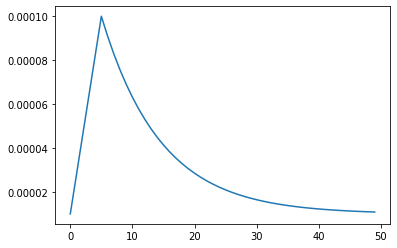

In [80]:
EPOCHS = 50


start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * strategy.num_replicas_in_sync
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .9

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
      
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

rang = tf.range(EPOCHS).numpy()
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [11]:
ES = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0.001, patience=20, mode='max', restore_best_weights=True)
TB = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(LOGS_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)
CKPT = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, 'ckpt') , 
                                          monitor='val_sparse_categorical_accuracy', 
                                          mode='max', 
                                          save_best_only=True, 
                                          save_weights_only=True)
model3.fit(train_data, 
          validation_data=valid_data, 
          steps_per_epoch=train_steps, 
          epochs=EPOCHS, 
          validation_steps=valid_steps, 
          verbose=0, 
          callbacks=[ES, TB, lr_callback, CKPT]
         )


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.

Epoch 00002: LearningRateScheduler reducing learning rate to 2.8000000000000003e-05.

Epoch 00003: LearningRateScheduler reducing learning rate to 4.6e-05.

Epoch 00004: LearningRateScheduler reducing learning rate to 6.4e-05.

Epoch 00005: LearningRateScheduler reducing learning rate to 8.2e-05.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0001.

Epoch 00007: LearningRateScheduler reducing learning rate to 8.2e-05.

Epoch 00008: LearningRateScheduler reducing learning rate to 6.760000000000002e-05.

Epoch 00009: LearningRateScheduler reducing learning rate to 5.608000000000001e-05.

Epoch 00010: LearningRateScheduler reducing learning rate to 4.686400000000001e-05.

Epoch 00011: LearningRateScheduler reducing learning rate to 3.949120000000001e-05.

Epoch 00012: LearningRateScheduler reducing learning rate to 3.359296000000001e-05.

Epoch 00013: LearningRateScheduler reducing learning rate to 2.88

### Inspecting the accuracy of the model

Accuracy: 46.10%
Confusion Matrix


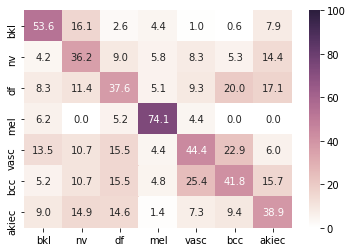

In [39]:
y_pred = tf.constant([], tf.int32)
y_true = tf.constant([], tf.int32)
for x, y in valid_data.take(valid_steps):
    y_pred = tf.concat([y_pred, tf.cast(model3.predict_classes(x), tf.int32)], axis=0)
    y_true = tf.concat([y_true, tf.cast(y, tf.int32)], axis=0)
    
cm = tf.math.confusion_matrix(y_true, y_pred)
# cmap = sns.cubehelix_palette(light=1, as_cmap=True)
cmap = 'Blues'
sns.heatmap(100*cm/tf.reduce_sum(cm, axis=1), annot=True, vmin=0.0, vmax=100., 
                  xticklabels = LABELS, yticklabels= LABELS, 
                  fmt='.1f', cmap=cmap)

print(f'Accuracy: {100* tf.reduce_mean(tf.cast(y_true == y_pred, tf.float32)).numpy():.2f}%')
print('Confusion Matrix')

In [13]:
model3.save(MODEL_DIR)

In [96]:
ds = tf.data.Dataset.from_tensor_slices((tf.random.uniform(shape=[100],dtype=tf.int32, minval=1, maxval=10),
                                        tf.random.uniform(shape=[100],dtype=tf.int32, minval=1, maxval=10)))
for x,y in ds:
    print(x.numpy(), y.numpy())

8 3
6 5
7 3
8 9
4 7
3 6
5 6
7 6
3 1
6 2
7 8
6 5
7 5
4 3
6 1
7 6
6 4
3 2
4 5
2 1
6 8
8 3
2 6
3 7
9 6
3 9
7 4
2 5
2 4
4 1
6 1
6 7
4 6
4 3
2 8
3 9
3 8
5 5
7 8
9 5
6 7
7 6
5 9
1 5
1 9
8 7
2 3
6 8
6 1
4 7
7 9
1 9
9 4
5 9
9 1
7 8
9 9
7 8
8 8
7 7
4 8
5 4
5 6
5 7
6 9
6 1
5 9
5 8
1 4
9 5
4 8
6 4
6 2
8 6
6 8
1 7
3 8
4 3
1 9
1 1
5 7
4 4
1 4
4 5
1 2
1 6
6 2
6 1
9 3
3 6
3 4
7 5
5 2
7 1
9 2
8 8
3 9
9 6
2 1
8 7


In [97]:
ds_s = ds.map(lambda x,y: (x*tf.ones_like(tf.range(x)),y*tf.ones_like(tf.range(y))))
for x,y in ds_s.take(10):
    print(x.numpy(), y.numpy())

[8 8 8 8 8 8 8 8] [3 3 3]
[6 6 6 6 6 6] [5 5 5 5 5]
[7 7 7 7 7 7 7] [3 3 3]
[8 8 8 8 8 8 8 8] [9 9 9 9 9 9 9 9 9]
[4 4 4 4] [7 7 7 7 7 7 7]
[3 3 3] [6 6 6 6 6 6]
[5 5 5 5 5] [6 6 6 6 6 6]
[7 7 7 7 7 7 7] [6 6 6 6 6 6]
[3 3 3] [1]
[6 6 6 6 6 6] [2 2]


In [111]:
ds_b = ds_s.apply(tf.data.experimental.bucket_by_sequence_length(lambda x,y: tf.math.maximum(tf.shape(x),tf.shape(y)), 
                                                               bucket_boundaries=[3,6,10],
                                                               bucket_batch_sizes=4*[10],
                                                            ))

In [112]:
for n, (x,y) in ds_b.enumerate():
    print(f'\n\nBatch number {n}\n')
    print(x.numpy(), '\n')
    print(y.numpy())



Batch number 0

[[8 8 8 8 8 8 8 8]
 [6 6 6 6 6 6 0 0]
 [7 7 7 7 7 7 7 0]
 [8 8 8 8 8 8 8 8]
 [4 4 4 4 0 0 0 0]
 [3 3 3 0 0 0 0 0]
 [5 5 5 5 5 0 0 0]
 [7 7 7 7 7 7 7 0]
 [6 6 6 6 6 6 0 0]
 [7 7 7 7 7 7 7 0]] 

[[3 3 3 0 0 0 0 0 0]
 [5 5 5 5 5 0 0 0 0]
 [3 3 3 0 0 0 0 0 0]
 [9 9 9 9 9 9 9 9 9]
 [7 7 7 7 7 7 7 0 0]
 [6 6 6 6 6 6 0 0 0]
 [6 6 6 6 6 6 0 0 0]
 [6 6 6 6 6 6 0 0 0]
 [2 2 0 0 0 0 0 0 0]
 [8 8 8 8 8 8 8 8 0]]


Batch number 1

[[6 6 6 6 6 6 0 0 0]
 [7 7 7 7 7 7 7 0 0]
 [6 6 6 6 6 6 0 0 0]
 [7 7 7 7 7 7 7 0 0]
 [6 6 6 6 6 6 0 0 0]
 [6 6 6 6 6 6 0 0 0]
 [8 8 8 8 8 8 8 8 0]
 [2 2 0 0 0 0 0 0 0]
 [3 3 3 0 0 0 0 0 0]
 [9 9 9 9 9 9 9 9 9]] 

[[5 5 5 5 5 0 0 0]
 [5 5 5 5 5 0 0 0]
 [1 0 0 0 0 0 0 0]
 [6 6 6 6 6 6 0 0]
 [4 4 4 4 0 0 0 0]
 [8 8 8 8 8 8 8 8]
 [3 3 3 0 0 0 0 0]
 [6 6 6 6 6 6 0 0]
 [7 7 7 7 7 7 7 0]
 [6 6 6 6 6 6 0 0]]


Batch number 2

[[3 3 3 0 0 0 0 0 0]
 [7 7 7 7 7 7 7 0 0]
 [6 6 6 6 6 6 0 0 0]
 [6 6 6 6 6 6 0 0 0]
 [4 4 4 4 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0]
 [3 3 3 0 0 

In [91]:
list(range(4))

[0, 1, 2, 3]